In [1]:
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline




## Load Quijote data to compare against:


In [2]:
scale_fac_all = np.loadtxt('/projects/bdne/spandey3/temp/camels_snap_scalefac.txt')
snap_num_test = [50,70,90]
scale_fac_test = scale_fac_all[snap_num_test]
z_test = 1/scale_fac_test - 1
print(z_test)
import numpy as np
import readgadget
import dill
save_Pmm_Quijote = {}
delta_mm_Quijote = {}
MAS = 'CIC'
BoxSize = 1000.
try:
    saved_all = dill.load(open('/projects/bdne/spandey3/temp/save_delta_quijote.pk','rb'))['delta']
    loaded_file = True
except:
    loaded_file = False

for ji, snapnum in enumerate(snap_num_test):
    # if loaded_file:
    try:
        delta = saved_all[f'{scale_fac_test[ji]:.3f}']
    except:
        print(snapnum, f'{scale_fac_test[ji]:.3f}')
        try:
            snapshot = f'/projects/bdne/spandey3/temp/snapdir_0{snapnum}/snap_0{snapnum}'
            header   = readgadget.header(snapshot)
        except:
            snapshot = f'/scratch/bdne/spandey3/fiducial_HR/snapdir_0{snapnum}/snap_0{snapnum}'
        ptype    = [1] #[1](CDM), [2](neutrinos) or [1,2](CDM+neutrinos)

        # read header
        header   = readgadget.header(snapshot)
        BoxSize  = header.boxsize/1e3  #Mpc/h
        Nall     = header.nall         #Total number of particles
        Masses   = header.massarr*1e10 #Masses of the particles in Msun/h
        Omega_m  = header.omega_m      #value of Omega_m
        Omega_l  = header.omega_l      #value of Omega_l
        h        = header.hubble       #value of h
        redshift = header.redshift     #redshift of the snapshot
        Hubble   = 100.0*np.sqrt(Omega_m*(1.0+redshift)**3+Omega_l)#Value of H(z) in km/s/(Mpc/h)

        # read positions, velocities and IDs of the particles
        pos = readgadget.read_block(snapshot, "POS ", ptype)/1e3 #positions in Mpc/h
        delta = np.zeros((Ngrid, Ngrid, Ngrid), dtype=np.float32)
        MASL.MA(pos[:].astype(np.float32), delta, BoxSize, MAS)
        delta = delta.astype(np.float32)
        delta = -1 + delta/np.mean(delta)
    import Pk_library as PKL
    Pk_mm = PKL.Pk(delta, BoxSize, axis=0, MAS=MAS)
    delta_mm_Quijote[f'{scale_fac_test[ji]:.3f}'] = delta
    save_Pmm_Quijote[f'{scale_fac_test[ji]:.3f}'] = Pk_mm



[1.60423452 0.61376409 0.        ]

Computing power spectrum of the field...
Time to complete loop = 0.54
Time taken = 0.80 seconds

Computing power spectrum of the field...
Time to complete loop = 0.54
Time taken = 0.80 seconds

Computing power spectrum of the field...
Time to complete loop = 0.54
Time taken = 0.80 seconds


## Configure pmwd. Get transfer function from CAMB. Correctly estimate As and initialize the cosmology for given sigma8. There is also now an additional `a_save` array at which the code will output the particle positions and velocities



In [3]:
import jax.numpy as jnp
from pmwd import (
    Configuration, Cosmology, boltzmann, linear_modes, lpt, nbody)
    
from pmwd.pm_util import fftinv

def get_camb_transfer(cosmo):
    import camb
    sigma8=cosmo[4]
    ns=cosmo[3]
    Om=cosmo[0]
    Ob=cosmo[1]
    h=cosmo[2]
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=h*100,
                    ombh2=Ob * h ** 2,
                    omch2=(Om - Ob) * h ** 2,
                    mnu=0.0,
                    omk=0,
                    )
    As_fid = 2.13e-9
    pars.InitPower.set_params(As=As_fid, ns=ns, r=0)
    pars.set_matter_power(redshifts=[0.], kmax=1000)
    pars.NonLinear = camb.model.NonLinear_none
    results = camb.get_results(pars)
    sigma8_camb = results.get_sigma8()[0]
    As_new = (sigma8 / sigma8_camb) ** 2 * As_fid
    pars.InitPower.set_params(As=As_new, ns=ns, r=0)
    results = camb.get_results(pars)
    data_transfer = results.get_matter_transfer_data().transfer_data
    transfer_kh = data_transfer[0,:,0]
    transfer_val = data_transfer[7,:,0]
    transfer_val /= transfer_val[0]
    return As_new*1e9, transfer_kh, transfer_val


def configure_pmwd(
    N, L, supersampling, B, ai, af, N_steps, cosmo, a_save,a_snapshots,
):
    # Configure simulation
    N = N*supersampling
    ptcl_spacing = L/N
    ptcl_grid_shape = (N,)*3
    pmconf = Configuration(
        ptcl_spacing, ptcl_grid_shape,
        a_start=ai, a_stop=af,
        a_nbody_num = N_steps,
        a_save=a_save,
        a_snapshots=a_snapshots,
        transfer_fit=False,
        # transfer_fit=True,
        mesh_shape=B)

    A_s_1e9, transfer_kh, transfer_val = get_camb_transfer(cosmo)
    pmcosmo = Cosmology(
        pmconf, A_s_1e9=A_s_1e9,
        n_s=cosmo[3], Omega_m=cosmo[0],
        Omega_b=cosmo[1], h=cosmo[2],
        transfer_k_inp=jnp.array(transfer_kh),
        transfer_val_inp=jnp.array(transfer_val),
        )

    # Boltzmann
    pmcosmo = boltzmann(pmcosmo, pmconf)
    return pmconf, pmcosmo


def gen_white_noise(N, seed=5):
    num_modes_last_d = N // 2 + 1
    with open('/projects/bdne/spandey3/temp/wn_5.dat', 'rb') as f:
            _ = np.fromfile(f, np.uint32, 1)[0]
            modes = np.fromfile(f, np.complex128, -1)
            modes = modes.reshape((N, N, num_modes_last_d))    
    return modes

N = 256
supersampling = 1
L = 1000.
B = 1.69
zi = 9.0
ai = 1/(1+zi)
af = 0.99
N_steps = 30
cosmo = [0.3175, 0.049, 0.6711, 0.9624, 0.834]
wn = gen_white_noise(N*supersampling)

pmconf, pmcosmo = configure_pmwd(
        N=N, L=L,
        supersampling=supersampling,
        B=B, ai=ai, af=af,
        N_steps=N_steps, cosmo=cosmo,
        a_save=jnp.array(scale_fac_test),
        a_snapshots=(0,af)
        )



2024-10-23 14:04:51.431119: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Run the PM code by first getting ICs (which we have saved already), running 2nd order LPT and then PM steps


In [4]:
ic = linear_modes(wn, pmcosmo, pmconf)
ptcl, obsvbl = lpt(ic, pmcosmo, pmconf)
ptcl_all_save, _ = nbody(ptcl, obsvbl, pmcosmo, pmconf)
pos_all_save = {}
vel_all_save = {}
for key in list(ptcl_all_save.keys()):
    pos_all_save[key] = np.array(ptcl_all_save[key].pos())
    vel = np.array(ptcl_all_save[key].vel)
    vel *= 100  # km/s
    vel_all_save[key] = vel



## Estimate and save the auto-power spectra of PM

In [5]:
save_Pmm = {}
delta_mm = {}
for key in list(pos_all_save.keys()):
    import MAS_library as MASL
    Ngrid = N
    BoxSize = L
    MAS = 'CIC'
    delta = np.zeros((Ngrid, Ngrid, Ngrid), dtype=np.float32)
    pos = pos_all_save[key]
    MASL.MA(pos[:].astype(np.float32), delta, BoxSize, MAS)
    delta = delta.astype(np.float32)
    delta = -1 + delta/np.mean(delta)

    import Pk_library as PKL
    Pk_mm = PKL.Pk(delta, BoxSize, axis=0, MAS=MAS)
    delta_mm[key] = delta
    save_Pmm[key] = Pk_mm

    


Computing power spectrum of the field...
Time to complete loop = 0.54
Time taken = 0.83 seconds

Computing power spectrum of the field...
Time to complete loop = 0.54
Time taken = 0.82 seconds

Computing power spectrum of the field...
Time to complete loop = 0.54
Time taken = 0.82 seconds


## Get the cross-power spectra between Quijote and PM

In [6]:
save_XPmm = {}
for af in scale_fac_test:
    delta1 = delta_mm[f'{af:.3f}']
    delta2 = delta_mm_Quijote[f'{af:.3f}']
    Pk = PKL.XPk([delta1,delta2], BoxSize, axis=0, MAS=['CIC','CIC'], threads=1)
    save_XPmm[f'{af:.3f}'] = Pk




Computing power spectra of the fields...
Time FFTS = 0.55
Time loop = 0.36
Time taken = 0.92 seconds

Computing power spectra of the fields...
Time FFTS = 0.55
Time loop = 0.36
Time taken = 0.92 seconds

Computing power spectra of the fields...
Time FFTS = 0.56
Time loop = 0.36
Time taken = 0.92 seconds


## Plot the cross-power spectra

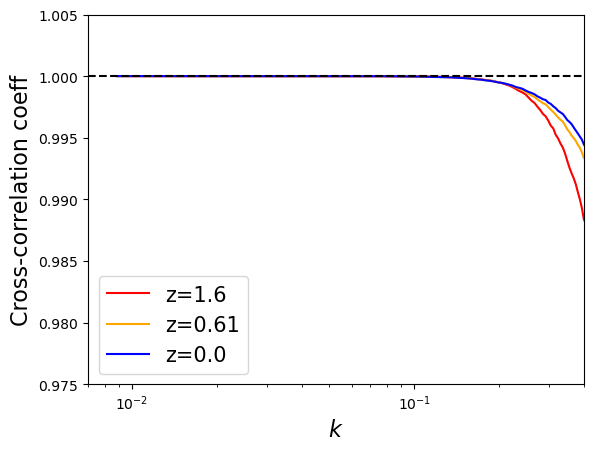

In [9]:
pl.figure()
colors_all = ['r', 'orange', 'blue', 'tomato', 'k']
for ji, af in enumerate(scale_fac_test):
    z = 1/af - 1
    pl.plot(save_XPmm[f'{af:.3f}'].k3D, save_XPmm[f'{af:.3f}'].XPk[:,0,0]/np.sqrt(save_XPmm[f'{af:.3f}'].Pk[:,0,0]*save_XPmm[f'{af:.3f}'].Pk[:,0,1]), ls='-', marker='', color=colors_all[ji], label='z=' + str(np.round(float(z),2)))
pl.xscale('log')
pl.xlim(7e-3, 0.4)
pl.axhline(1.0,ls='--', color='k')
pl.ylim(0.975, 1.005)
pl.xlabel(r'$k$', fontsize=16)
pl.ylabel(r'Cross-correlation coeff', fontsize=16)
pl.legend(fontsize=15)
pl.show()



## Plot the transfer function:

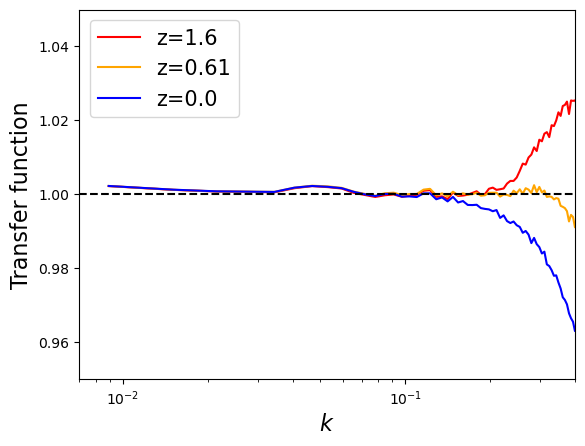

In [8]:
pl.figure()
colors_all = ['r', 'orange', 'blue', 'tomato', 'k']
for ji, af in enumerate(scale_fac_test):
    z = 1/af - 1
    pl.plot(save_XPmm[f'{af:.3f}'].k3D, save_XPmm[f'{af:.3f}'].Pk[:,0,0]/save_XPmm[f'{af:.3f}'].Pk[:,0,1], ls='-', marker='', color=colors_all[ji], label='z=' + str(np.round(z,2)))

pl.xscale('log')
# pl.yscale('log')
pl.xlim(7e-3, 0.4)
pl.ylim(0.95, 1.05)
pl.axhline(1.0,ls='--', color='k')
pl.xlabel(r'$k$', fontsize=16)
pl.ylabel(r'Transfer function', fontsize=16)
pl.legend(fontsize=15)
pl.show()

